### Importación Bibliotecas

In [ ]:
!pip install imutils --quiet
!pip install livelossplot --quiet

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import sys
print(f'{sys.version}')
print(f'keras {keras.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'numpy {np.__version__}')

import pandas as pd
import os
from imutils import paths
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score

from functions import create_model, get_size, train_valid_generator, plot_heatmap, add_value_labels

Using TensorFlow backend.


3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
keras 2.3.0
tensorflow 2.1.3
numpy 1.18.5


In [ ]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


### Importación Imágenes para Entrenamiento

In [ ]:
# Copiar las imágenes destinadas a los entrenamientosa a la instancia de Jupyter desde s3 de AWS. Hace falta hacerlo solamente la primera vez
#. !aws s3 sync s3://focusondrivinghenry/img './img' --quiet

In [ ]:
import os
print(get_size()/1000, 'bytes')

3688487.639 bytes


### Exploratory Data Analysis (Train Data)

In [ ]:
train_data = f'./img/train'
test_data = f'./img/test'
class_subset = sorted(os.listdir(train_data))
ac_labels = {"c0": "safe driving",
             "c1": "texting - right",
             "c2": "talking on the phone - right",
             "c3": "texting - left",
             "c4": "talking on the phone - left",
             "c5": "operating the radio",
             "c6": "drinking",
             "c7": "reaching behind",
             "c8": "hair and makeup",
             "c9": "talking to passenger"}

In [ ]:
print(f'train_data {train_data}')
print(f'test_data {test_data}')
print(f'class_subset {class_subset}')

train_data ./img/train
test_data ./img/test
class_subset ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


### Comprobación de que las imágenes destinadas a los entrenamientos tienen las mismas dimensiones

In [ ]:
df = pd.DataFrame()
df_all_elements = pd.DataFrame()
directories = os.listdir(train_data)
for directory in directories:
    _dir = f'{train_data}/{directory}'
    print(f'directory {_dir}')
    len_files = len(os.listdir(_dir))
    img_list = paths.list_images(_dir)
    shape = []
    for i, img_path in enumerate(img_list):
        shape.append(cv2.imread(img_path).shape)
        if i > 5:
            break

    _directory = [directory] * len(shape)
    _label = [ac_labels[directory]] * len(shape)
    df_all_elements = df_all_elements.append(pd.DataFrame({'class': _directory,
                                                          'shape': shape,
                                                          'label': _label}),
                                            ignore_index=True)

    result = False
    listOfStrings = df_all_elements['shape']
    if len(listOfStrings) > 0:
        result = all(elem == listOfStrings[0] for elem in listOfStrings)
    if result:
        print("All Elements in List are Equal")
    else:
        print("All Elements in List are Not Equal")

    df = df.append(pd.DataFrame({'class': [directory],
                                'len': [len_files],
                                'shape': [listOfStrings[0]],
                                'label': [ac_labels[directory]]}),
                  ignore_index=True)

directory ./img/train/c6
All Elements in List are Equal
directory ./img/train/c9
All Elements in List are Equal
directory ./img/train/c7
All Elements in List are Equal
directory ./img/train/c3
All Elements in List are Equal
directory ./img/train/c8
All Elements in List are Equal
directory ./img/train/c2
All Elements in List are Equal
directory ./img/train/c4
All Elements in List are Equal
directory ./img/train/c0
All Elements in List are Equal
directory ./img/train/c5
All Elements in List are Equal
directory ./img/train/c1
All Elements in List are Equal


In [ ]:
df

,class,len,shape,label
0,c6,2325,"(480, 640, 3)",drinking
1,c9,2129,"(480, 640, 3)",talking to passenger
2,c7,2002,"(480, 640, 3)",reaching behind
3,c3,2346,"(480, 640, 3)",texting - left
4,c8,1911,"(480, 640, 3)",hair and makeup
5,c2,2317,"(480, 640, 3)",talking on the phone - right
6,c4,2326,"(480, 640, 3)",talking on the phone - left
7,c0,2489,"(480, 640, 3)",safe driving
8,c5,2312,"(480, 640, 3)",operating the radio
9,c1,2267,"(480, 640, 3)",texting - right


### Distribución del número de imágenes por categorías

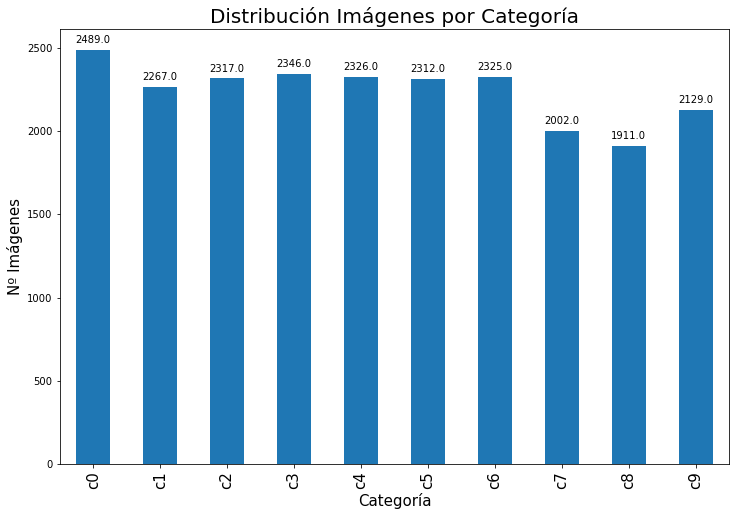

In [ ]:
frequencies = list(df['len'].values)

freq_series = pd.Series(frequencies)

x_labels = list(df['class'].values)

plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Distribución Imágenes por Categoría', size=20)
ax.set_xlabel('Categoría', size=15)
ax.set_ylabel('Nº Imágenes', size=15)
ax.set_xticklabels(x_labels, size=15)



# Call the function above. All the magic happens there.
add_value_labels(ax)

plt.savefig("image.png")

### Preparación Conjunto de Imágenes para Entrenamiento y Test

In [ ]:
BATCH_SIZE = 32
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 
testgen = test_generator.flow_from_directory(test_data,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

### Pruebas "Data Augmentation"

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img = load_img('./img/train/c0/img_100026.jpg')
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)
i = 0
for batch in train_generator.flow(x, batch_size=1,
                                 save_to_dir='./img/zoom',
                                 save_prefix='zoom4',
                                 save_format='jpeg'):
    i += 1
    if i > 10:
        break

### Definición del Modelo

In [ ]:
n_model = input('generate model (1, 2, 3, 4, 5): ')
input_shape = (224, 224, 3)
n_classes=len(class_subset)
optim = Adam(lr=0.0001)
fine_tune=2
n_epochs = 25

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                        patience=10,
                        restore_best_weights=True,
                        mode='min')

for n_model in [1, 2, 3, 4, 5]:
    traingen, validgen = train_valid_generator(n_model, train_data)
    n_steps = traingen.samples // BATCH_SIZE
    n_val_steps = validgen.samples // BATCH_SIZE

    # ModelCheckpoint callback - save best weights
    tl_checkpoint_1 = ModelCheckpoint(filepath=f'./model/model{n_model}.hdf5',
                                    save_best_only=True,
                                    verbose=1)

    
    # Ajuste del Modelo con fine-tuning
    model = create_model(input_shape, n_classes, optim, fine_tune, n_model)
    model = model.fit(traingen,
                      epochs=n_epochs,
                      validation_data=validgen,
                      steps_per_epoch=n_steps, 
                      validation_steps=n_val_steps,
                      # callbacks=[tl_checkpoint_1, early_stop, PlotLossesCallback()],
                      callbacks=[tl_checkpoint_1, PlotLossesCallback()],
                      verbose=1)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/tas

### Comprobación del Accuracy del Modelo

In [ ]:
true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
fine_tune=2

model = create_model(input_shape, n_classes, optim, fine_tune, n_model)
model.load_weights(f'./model/model{n_model}.hdf5')
model_pred = model.predict(testgen)
model_pred_classes = np.argmax(model_pred, axis=1)
model_acc_ft = accuracy_score(true_classes, model_pred_classes)
print("VGG16 Model {} Accuracy with Fine-Tuning: {:.2f}%".format(i, model_acc_ft * 100))

# Matriz de confusión del modelo generado

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

plot_heatmap(true_classes, model_pred_classes, class_names, axes[i], title=f"model{n_model}")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()